# Library Imports and Setup

In [1]:
# Install the mxnet library required for certain functionalities in SageMaker
!pip install mxnet

# AWS SageMaker and Boto3
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.image_uris import retrieve
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
import boto3
from botocore.exceptions import ClientError

# Data Manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Libraries
import tarfile
import mxnet as mx
import datetime
import json
import time
from tabulate import tabulate
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 41.7 MB/s eta 0:00:00:00:0100:01
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# SageMaker Setup and Configuration

In [2]:
# Initialize a SageMaker Session
# A SageMaker Session helps in managing the interactions with the AWS SageMaker service, such as creating and training models, and deploying endpoints.
sagemaker_session = sagemaker.Session()

# Retrieve the IAM role
# The IAM role is required by SageMaker to access AWS resources (e.g., S3 buckets) on your behalf.
role = get_execution_role()

# Identify the AWS Region of the SageMaker Session
# This information is used to ensure that resources are created in the same region as the SageMaker session.
region = sagemaker_session.boto_region_name

# Create Boto3 Clients for S3 and SageMaker
# These clients enable programmatic access to S3 and SageMaker services for operations like uploading data and creating training jobs.
s3_client = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')

# Retrieve the Docker image URI for the KMeans algorithm
# This URI is specific to the AWS region and is used to pull the appropriate image for training.
image_uri = retrieve('kmeans', region)

# Define the Default S3 Bucket for SageMaker
# SageMaker requires an S3 bucket to store training data, models, and outputs. Here, we use the session's default bucket.
bucket = sagemaker_session.default_bucket()

# Set the S3 Prefix for Storing Data
# The prefix is used to organize the data in the bucket, making it easier to manage and locate.
prefix = 'sagemaker/wine/kmeans'

# Output the IAM Role ARN and AWS Region for verification
print("Execution Role ARN:", role)
print("AWS Region:", region)

Execution Role ARN: arn:aws:iam::891377000794:role/LabRole
AWS Region: us-east-1


# Load and Preprocess the Dataset

In [3]:
# Step 1: Load the Dataset
# Load the wine customers dataset from a CSV file into a Pandas DataFrame.
# This allows for easy data manipulation and analysis.
df = pd.read_csv('wine.csv')

# Step 2: Select Relevant Features
# Focus on the features 'Age', 'Annual Income (k$)', and 'Spending Score (1-100)' for analysis.
df = df[['Ash', 'Magnesium', 'Hue']]

# Step 3: Convert Data for Machine Learning
# Convert the selected DataFrame into a NumPy array of type 'float32'.
# This conversion is necessary as most machine learning frameworks work efficiently with NumPy arrays.
data_np = df.values.astype('float32')

# Step 4: Save Preprocessed Data
# Save the preprocessed dataset to a CSV file, without the index.
df.to_csv('wine_data_two.csv', index=False)

# Confirming the data has been preprocessed and saved.
print("Preprocessed dataset saved as 'wine_data_two.csv'.")

# Display the first few rows of the processed dataset to verify the preprocessing steps.
print(df.head())


Preprocessed dataset saved as 'wine_data_two.csv'.
    Ash  Magnesium   Hue
0  2.43        127  1.04
1  2.14        100  1.05
2  2.67        101  1.03
3  2.50        113  0.86
4  2.87        118  1.04


# Plot the data

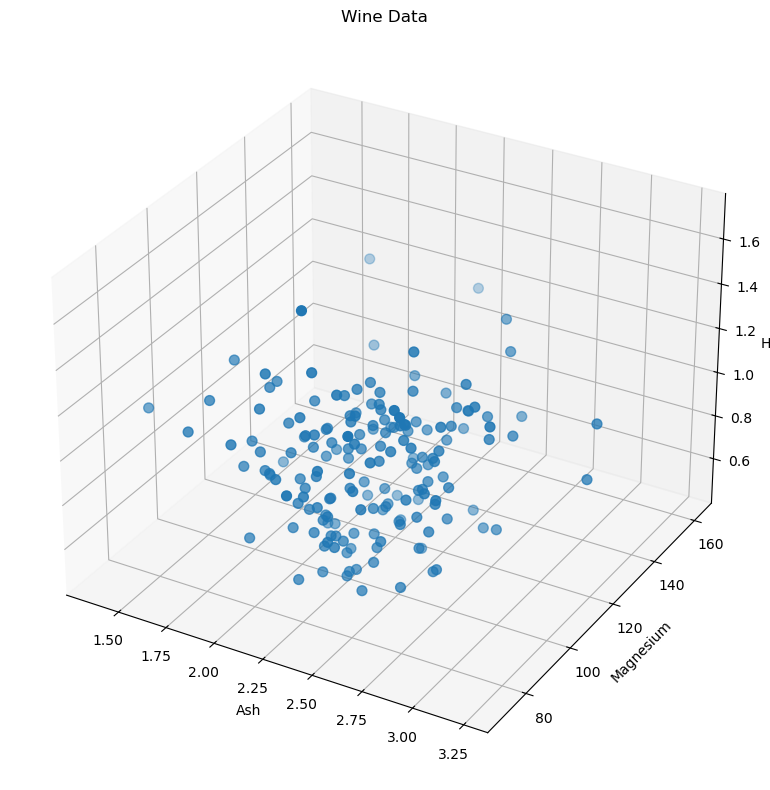

In [4]:
# Initialize a figure for 3D plotting
fig = plt.figure(figsize=(12, 8))

# Add a 3D subplot to the figure
# '111' indicates 1x1 grid, first subplot. 'projection='3d'' specifies the 3D projection.
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for customer data
# Customers are plotted based on their 'Ash', 'Magnesium', and 'Hue'
ax.scatter(df['Ash'], df['Magnesium'], df['Hue'], s=50)

# Set the title of the plot
ax.set_title('Wine Data')

# Label the axes
ax.set_xlabel('Ash')
ax.set_ylabel('Magnesium')
ax.set_zlabel('Hue')

# Adjust the layout to ensure everything fits without overlaps
plt.tight_layout()

# Display the plot
plt.show()


# KMeans Model Training

In [5]:
# Define the range of k values for the KMeans clustering
# This range will determine how many models we train, each with a different number of clusters.
k_values = range(2, 8)

# Initialize lists to keep track of the S3 paths for the trained models and their training job names.
model_paths = []
training_jobs = []

# Set the output path in the S3 bucket for the trained models
# This path will be used to store the output (model artifacts) of each training job.
output_path = f's3://{sagemaker_session.default_bucket()}/sagemaker/wine/kmeans/output'

# Iterate over each k value to train a separate KMeans model for that number of clusters
for k in k_values:
    # Generate a unique job name for each training job based on the k value
    job_name = f'kmeans-wine-{k}'
    
    # Initialize the KMeans estimator from SageMaker with the specific k value
    # Configuration includes instance type, number of instances, and the specified k value.
    kmeans = KMeans(
        sagemaker_session=sagemaker_session,
        role=role,
        instance_count=1,
        instance_type='ml.m5.large',
        k=k,
        output_path=output_path,
        job_name=job_name,
        feature_dim=4  # Specify the number of features in the input data
    )
    
    # Start the training job for the KMeans model
    # We use 'wait=False' to start each training job asynchronously.
    kmeans.fit(kmeans.record_set(data_np), wait=False)
    training_jobs.append((k, kmeans.latest_training_job.name))

# After initiating all training jobs, we wait for each to complete and collect their model URIs
for k, job_name in training_jobs:
    # Wait for the completion of the training job
    sagemaker_client.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    
    # Retrieve the S3 URI of the model artifacts for the completed training job
    training_job_description = sagemaker_client.describe_training_job(TrainingJobName=job_name)
    model_s3_uri = training_job_description['ModelArtifacts']['S3ModelArtifacts']
    model_paths.append((k, model_s3_uri))

# Print the S3 paths of the model artifacts for all trained models
# This provides a clear reference to the location of each model for further analysis or deployment.
headers = ['k Value', 'S3 Model Artifact Path']
print(tabulate(model_paths, headers=headers))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2024-03-28-17-42-34-143
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2024-03-28-17-42-34-790
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris

  k Value  S3 Model Artifact Path
---------  ---------------------------------------------------------------------------------------------------------------------
        2  s3://sagemaker-us-east-1-891377000794/sagemaker/wine/kmeans/output/kmeans-2024-03-28-17-42-34-143/output/model.tar.gz
        3  s3://sagemaker-us-east-1-891377000794/sagemaker/wine/kmeans/output/kmeans-2024-03-28-17-42-34-790/output/model.tar.gz
        4  s3://sagemaker-us-east-1-891377000794/sagemaker/wine/kmeans/output/kmeans-2024-03-28-17-42-37-548/output/model.tar.gz
        5  s3://sagemaker-us-east-1-891377000794/sagemaker/wine/kmeans/output/kmeans-2024-03-28-17-42-38-990/output/model.tar.gz
        6  s3://sagemaker-us-east-1-891377000794/sagemaker/wine/kmeans/output/kmeans-2024-03-28-17-42-39-883/output/model.tar.gz
        7  s3://sagemaker-us-east-1-891377000794/sagemaker/wine/kmeans/output/kmeans-2024-03-28-17-42-41-201/output/model.tar.gz


# Determine K through Elbow Plot

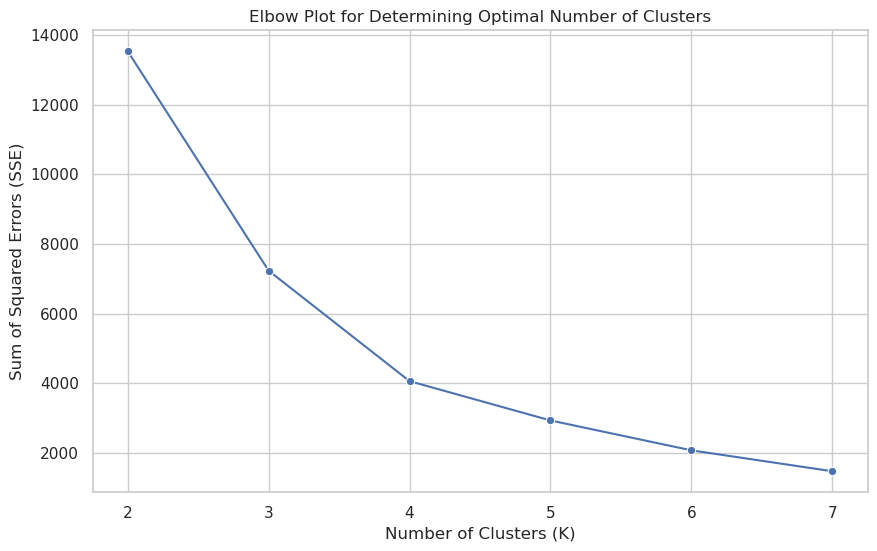

In [6]:
# List to store the Sum of Squared Errors (SSE) for each value of K
sse_values = []

# Iterate over each trained model's path to calculate SSE
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)

        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')

        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()

        # Calculate distances from each point to each centroid
        distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))

        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)

        # Calculate SSE for this value of K
        sse = np.sum((data_np - centroids[closest_centroids])**2)
        sse_values.append(sse)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Create and display the Elbow Plot using seaborn and matplotlib
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=[k for k, _ in model_paths], y=sse_values, marker='o')
plt.title('Elbow Plot for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks([k for k, _ in model_paths])
plt.show()

# Determine K through using Silhouette Method

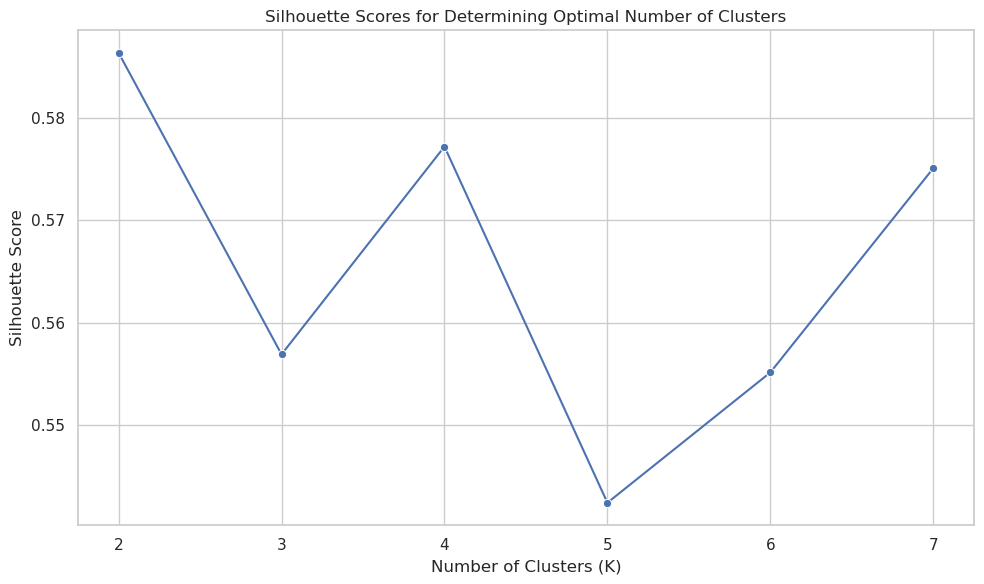

In [7]:
# List to store the silhouette scores for each value of K
silhouette_scores = []

# Iterate over each trained model's path to calculate its silhouette score
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)
        
        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()
        
        # Calculate distances from each point to each centroid
        distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        
        # Calculate the silhouette score for this value of K
        silhouette_score_value = silhouette_score(data_np, closest_centroids)
        silhouette_scores.append(silhouette_score_value)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Plot the silhouette scores for different values of K, if available
if silhouette_scores:  # Ensure the list is not empty
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=[k for k, _ in model_paths], y=silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Determining Optimal Number of Clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()  # Adjust the layout to make sure everything fits without overlap
    plt.show()
else:
    print("No silhouette scores to plot.")

# Visualize the centroids for the optimal K value and display the cluster assignments for each datapoint

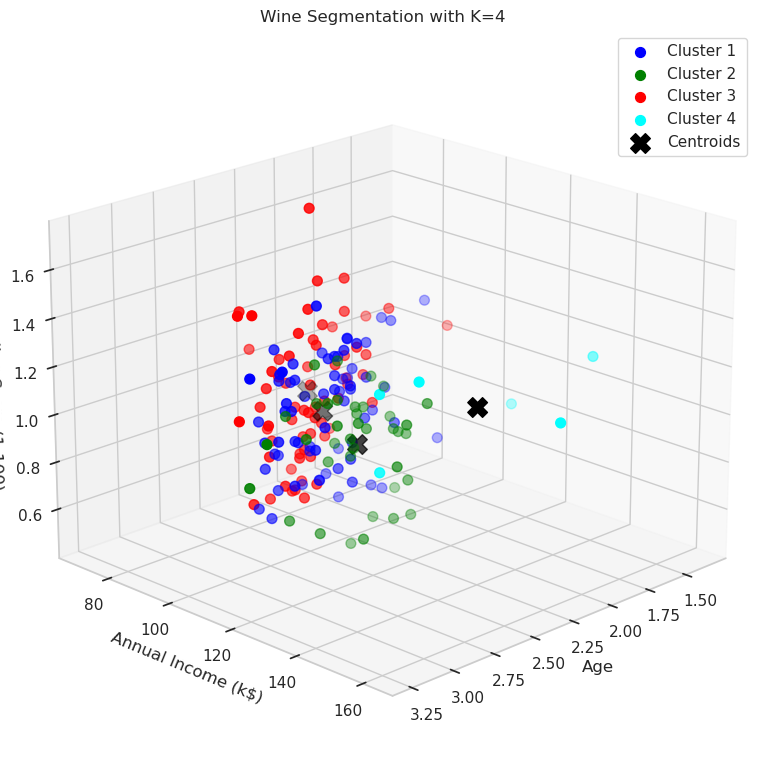

In [12]:
# Define best_k based on your optimal cluster count
best_k = 4

# Assuming model_paths is a list of tuples (k, model_s3_path) or a similar structure
best_model_path = next(model_s3_path for k, model_s3_path in model_paths if k == best_k)

# Download and extract the best model from S3
local_path = f'/tmp/model-k-{best_k}.tar.gz'
s3_client.download_file(bucket, best_model_path.replace(f's3://{bucket}/', ''), local_path)

with tarfile.open(local_path) as tar:
    tar.extractall(path=f'/tmp/k-{best_k}')

# Load the KMeans model parameters
kmeans_model_params = mx.ndarray.load(f'/tmp/k-{best_k}/model_algo-1')
centroids = kmeans_model_params[0].asnumpy()

# Calculate the distances and find the closest centroid for each data point
distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
closest_centroids = np.argmin(distances, axis=0)

# Visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot data points, color-coded by cluster assignment
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']
for i in range(best_k):
    cluster_points = data_np[closest_centroids == i]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], s=50, color=colors[i % len(colors)], label=f'Cluster {i+1}')

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=200, color='black', marker='X', label='Centroids')

# Customize the view angle for better understanding of the plot
ax.view_init(elev=20, azim=45)

# Set plot attributes
ax.set_title(f'Wine Segmentation with K={best_k}')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.legend()

plt.tight_layout()
plt.show()


# Model Deployment to SageMaker Endpoint

In [13]:
# Specify names for the endpoint and its configuration
endpoint_name = 'wine-kmeans'
endpoint_config_name = 'wine-kmeans'

# Function to wait for endpoint configuration deletion
def wait_for_endpoint_config_deletion(endpoint_config_name):
    print(f'Waiting for endpoint configuration "{endpoint_config_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
                break
            else:
                raise

# Check and delete the existing endpoint configuration if it exists
try:
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    wait_for_endpoint_config_deletion(endpoint_config_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')

# Function to wait for endpoint deletion
def wait_for_endpoint_deletion(endpoint_name):
    print(f'Waiting for endpoint "{endpoint_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" deleted.')
                break
            else:
                raise

# Check and delete the existing endpoint if it exists
try:
    sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    wait_for_endpoint_deletion(endpoint_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint "{endpoint_name}" does not exist.')

# Identify the best model based on prior analysis
best_k = 4  # Assuming best_k is determined through prior analysis
best_model_s3_uri = next(path for k, path in model_paths if k == best_k)

# Create a SageMaker Model object with the best model's artifacts
best_model = Model(
    model_data=best_model_s3_uri,
    image_uri=image_uri,
    role=role,
    sagemaker_session=sagemaker_session
)

# Deploy the model to an endpoint
# Note: This operation can take several minutes to complete.
predictor = best_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

print(f'Model deployed to endpoint: {endpoint_name}')

Endpoint configuration "wine-kmeans" already exists. Deleting...
Waiting for endpoint configuration "wine-kmeans" to be deleted...
Endpoint configuration "wine-kmeans" deleted.
Endpoint "wine-kmeans" already exists. Deleting...
Waiting for endpoint "wine-kmeans" to be deleted...


INFO:sagemaker:Creating model with name: kmeans-2024-03-28-17-57-11-899


Endpoint "wine-kmeans" deleted.


INFO:sagemaker:Creating endpoint-config with name wine-kmeans
INFO:sagemaker:Creating endpoint with name wine-kmeans


-------!Model deployed to endpoint: wine-kmeans


# Cluster Associations and Centroids

In [14]:
# Initialize a Predictor object for the deployed SageMaker endpoint
predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())

def get_user_input(prompt):
    """Function to get user input; allows quitting by typing 'quit'."""
    user_input = input(prompt).strip()
    if user_input.lower() == 'quit':
        return None
    return user_input

def validate_and_prompt(feature_name, feature_prompt):
    """Validate and repeatedly prompt until a valid input or 'quit' is entered."""
    while True:
        user_input = get_user_input(feature_prompt)
        if user_input is None:  # User chose to exit
            return None
        try:
            # Ensure input is a positive number for Age, Annual Income, and Spending Score
            # No specific check for Gender as it's not included in this interaction
            value = float(user_input)
            if value > 0:
                return str(value)
            else:
                print(f"Please enter a positive number for {feature_name}.")
        except ValueError:
            print(f"Invalid input. Please enter a number for {feature_name}.")

print("Cluster Prediction Program")
print("Enter the following information for a prediction, or type 'quit' to exit.")

while True:
    # Collect inputs from the user
    ash = validate_and_prompt('Ash', "Enter Ash: ")
    if ash is None: break
    magnesium = validate_and_prompt('Magnesium', "Enter Magnesium: ")
    if magnesium is None: break
    hue = validate_and_prompt('Hue', "Enter Hue: ")
    if hue is None: break

    # Prepare the data for prediction
    data = f'{ash},{magnesium},{hue}\n'

    # Make prediction
    try:
        response = predictor.predict(data)
        # Parse the prediction response
        response_json = json.loads(response)
        cluster = response_json['predictions'][0]['closest_cluster']
        distance = response_json['predictions'][0]['distance_to_cluster']
        # Print the cluster assignment
        print(f"The data point belongs to Cluster {int(cluster)} with a distance of {distance:.2f} to the cluster center.")
    except Exception as e:
        print(f"An error occurred during prediction: {str(e)}")

print("Program exited.")


Cluster Prediction Program
Enter the following information for a prediction, or type 'quit' to exit.


Enter Ash:  2.4
Enter Magnesium:  125
Enter Hue:  1.02


The data point belongs to Cluster 1 with a distance of 9.59 to the cluster center.


Enter Ash:  2.4
Enter Magnesium:  125
Enter Hue:  1.4


The data point belongs to Cluster 1 with a distance of 9.60 to the cluster center.


Enter Ash:  2.2
Enter Magnesium:  105
Enter Hue:  1.5


The data point belongs to Cluster 0 with a distance of 4.98 to the cluster center.


Enter Ash:  quit


Program exited.


# Delete the Endpoint and Endpoint Config

In [15]:
# Prompt for confirmation before proceeding with the deletion
confirmation = input("Are you sure you want to delete the endpoint and endpoint configuration? (yes/no): ")

if confirmation.lower() == 'yes':

    # Function to delete endpoint configuration
    def delete_endpoint_config(endpoint_config_name):
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            print(f'Endpoint configuration "{endpoint_config_name}" exists. Deleting...')
            sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
            print(f'Endpoint configuration "{endpoint_config_name}" deleted successfully.')
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
            else:
                raise

    # Function to delete the endpoint
    def delete_endpoint(endpoint_name):
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            print(f'Endpoint "{endpoint_name}" exists. Deleting...')
            sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
            print(f'Endpoint "{endpoint_name}" deleted successfully.')
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" does not exist.')
            else:
                raise

    # Delete the endpoint configuration
    delete_endpoint_config(endpoint_config_name)

    # Delete the endpoint
    delete_endpoint(endpoint_name)

else:
    print("Deletion cancelled. The endpoint and its configuration were not deleted.")

Are you sure you want to delete the endpoint and endpoint configuration? (yes/no):  yes


Endpoint configuration "wine-kmeans" exists. Deleting...
Endpoint configuration "wine-kmeans" deleted successfully.
Endpoint "wine-kmeans" exists. Deleting...
Endpoint "wine-kmeans" deleted successfully.
